In [43]:
import os
import torch
import random
import numpy as np
from PIL import Image
from torchmetrics.segmentation import DiceScore
from torchmetrics.classification import BinaryJaccardIndex
from model import MyUNet
from utils import get_all_pairs_path
from dataset import preprocess_image_mask
import matplotlib.pyplot as plt

In [44]:
model_path = 'Models/crossval/0769977b56/model_0769977b56_s42_fold5.pth'

In [45]:
dataset_dir = "Datasets/v0"
pairs_path = get_all_pairs_path(dataset_dir)
print(f"Successfully loaded {len(pairs_path)} pairs of images and masks.")

Successfully loaded 4817 pairs of images and masks.


In [46]:
pair = random.choice(pairs_path)
print(f"Randomly selected pair: {pair}")
preprocessed_image, preprocessed_mask = preprocess_image_mask(pair[0], pair[1])

Randomly selected pair: ['Datasets/v0/Images/image_8719d06c-cfca-4adf-a530-3c08fca5f8b6.png'
 'Datasets/v0/Masks/mask_8719d06c-cfca-4adf-a530-3c08fca5f8b6.png']


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = MyUNet(in_channels=3, out_channels=1, num_filters=[16, 32], n_convs=3)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

dice_metric = DiceScore(num_classes=2).to(device)
iou_metric = BinaryJaccardIndex(threshold=0.5).to(device)

with torch.no_grad():
    input_image, input_mask = preprocessed_image.to(device), preprocessed_mask.to(device)
    outputs = model(input_image.unsqueeze(0))
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > 0.5).float()

    dice_metric(outputs, input_mask.unsqueeze(0))
    iou_metric(outputs, input_mask.unsqueeze(0))

    print(f"Dice Score: {dice_metric.compute().item()}")
    print(f"IoU Score: {iou_metric.compute().item()}")


Using device: cpu
Dice Score: 0.9997979998588562
IoU Score: 0.999596118927002


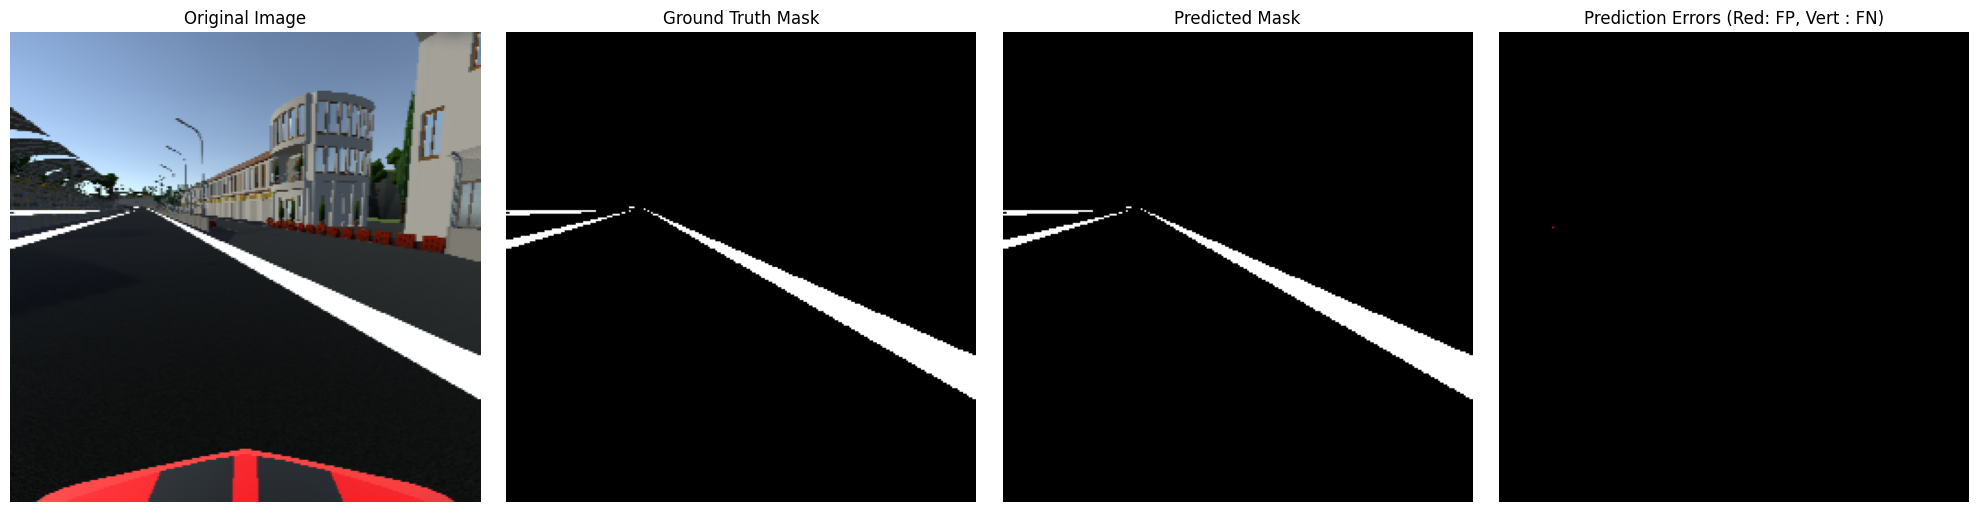

In [48]:
input_image_np = input_image.squeeze().cpu().numpy().transpose(1, 2, 0)  # Shape: (H, W, C)
input_mask_np = input_mask.squeeze().cpu().numpy()  # Shape: (H, W)
outputs_np = outputs.squeeze().cpu().numpy()  # Shape: (H, W)

fp = (outputs_np == 1) & (input_mask_np == 0)
fn = (outputs_np == 0) & (input_mask_np == 1)

diff_image = np.zeros((3, *input_image_np.shape[:2]), dtype=np.float32)

diff_image[0][fp] = 1.0  # Rouge pour Faux Positifs
diff_image[1][fn] = 1.0  # Vert pour Faux Négatifs

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Affichage de l'image originale
axes[0].imshow(input_image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Affichage du masque réel
axes[1].imshow(input_mask_np, cmap='gray')
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Affichage du masque prédit
axes[2].imshow(outputs_np, cmap='gray')
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

axes[3].imshow(diff_image.transpose(1, 2, 0))  # Convertir en (H, W, C) pour l'affichage
axes[3].set_title("Prediction Errors (Red: FP, Vert : FN)")
axes[3].axis('off')

# Afficher l'ensemble
plt.tight_layout()
plt.show()